## Part 1

In this section we create a class Boltzmann_N_spins which solves the ground state of the N-spin chain using gradient descent.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random as rnd
import scipy


class Boltzmann_N_spins:
    """Class Boltzmann computes an optimal wave function for
    a given hamiltonian and initial w = a, b, W """
    def __init__(self, hamiltonian, n = 2):
        self.n = n
        self.hamiltonian = hamiltonian    # function which is defined outside
        self.w_optimal = np.nan    # optimal w = a, b, W      
        self.psi_optimal = np.nan    # optimal psi corresponding to the optimal w
        self.min_energy = np.nan    # minimal energy corresponding to the optimal psi
        self.energy_optimization_history = []
        
    ########### PSI #################################
    
    def psi_M(self, S, w):    
        """Returns a component of a wavefunction
        in the S direction
        psi is given in form of an array and works for any number of spins"""
        a, b, W = w[0], w[1], w[2]
        psi = np.exp(np.sum(a * S))
        for i in range(len(W)):
            Fi = 2 * np.cosh(b[i] + np.sum(W[i] * S))
            psi *= Fi
        return psi

    def compute_psi(self, w):
        """Computes psi for w = a,b,W 
        psi is given in form of an array and works for any number of spins"""
        n = len(w[0])
        s = generate_spins(n)
        psi = np.zeros(2 ** n, dtype = 'complex')
        for i in range(len(psi)):
            psi[i] = self.psi_M(s[i], w)
        return psi
    
    def compute_psi_scipy(self, w_scipy):
        """Computes psi when for a given w_scipy"""
        w = self.convert_w_from_scipy(w_scipy)
        return self.compute_psi(w)
    
    def normalize(self, psi):
        """Returns normalized psi"""
        psi_star = np.transpose(np.conjugate(psi))
        return psi / np.sqrt(np.sum(psi_star @ psi))
        
    def show_psi(self, psi):
        """psi is a vector with lenght 2^n"""
        s = 'psi = '
        accuracy = '%.2f'
        for i in range(len(psi)):
            basis = bin(i)
            while len(basis) < len(bin(len(psi))) - 1:
                basis = basis[0:2] + '0' + basis[2:]
            if np.real(psi[i]) >= 0:
                s += '(' + str(accuracy % np.real(psi[i])) + ' + ' + str(accuracy % np.imag(psi[i])) + 'i)|' + basis[2:] + '>' + ' + '
            else:
                s += '(' + str(accuracy % np.real(psi[i])) + ' - ' + str(accuracy % np.imag(-psi[i])) + 'i)|' + basis[2:] + '>' + ' + '
        print(s[:-3])
    
    def show_psi_optimal(self):
        """Shows optimal psi"""
        if self.psi_optimal is np.nan:
            raise ValueError('The optimal psi is not computed yet')
        self.show_psi(self.psi_optimal)
    
    ########### PSI #################################
    ########### OMEGA ###############################
    
    def find_len_a(self, N):
        """Returns the size of a for a given length 
        N of w = a,b,W in a form of 1D array"""
        l = 0
        while 2 * l + l ** 2 != N:
            l += 1
        return l
    
    def convert_w_to_scipy(self, w):
        """Converts w = a, b, W into scipy form"""
        a, b, W = w[0], w[1], w[2]
        w_scipy = np.zeros(2 * (len(a) + len(b) + len(W) * len(W[0]))) 
        for i in range(len(a)):
            w_scipy[2 * i] = np.real(a[i])
            w_scipy[2 * i + 1] = np.imag(a[i])
        for i in range(len(b)):
            w_scipy[2 * (len(a) + i)] = np.real(b[i])
            w_scipy[2 * (len(a) + i) + 1] = np.imag(b[i])
        for i in range(len(W)):
            for j in range(len(W[0])):
                w_scipy[2 * (len(a) + len(b) + i * len(W) + j)] = np.real(W[i][j])
                w_scipy[2 * (len(a) + len(b) + i * len(W) + j) + 1] = np.imag(W[i][j])
        return w_scipy
    
    def convert_w_from_scipy(self, w_scipy):
        """From w in scipy form returns w = a, b, W"""
        w = np.zeros(len(w_scipy) // 2, dtype = 'complex')
        for i in range(len(w)):
            w[i] = w_scipy[2 * i] + 1j * w_scipy[2 * i + 1]
        l = self.find_len_a(len(w))
        a, b = w[:l], w[l : 2 * l]
        W = np.resize(w[2 * l + 1:], (l, l))
        return a, b, W
    
    def show_omega_optimal(self):
        """Shows optimal w"""
        w = self.w_optimal
        a, b, W = w[0], w[1], w[2]
        print('a = ', a, '\nb = ', b, '\nW = ', W)
        
    ########### OMEGA ###############################
    ########### ENERGY ##############################
    
    def avg_energy(self, psi):
        """Returns the average energy for a given  wavefunciton
        and a given hamiltonian
         =  / """
        psi_star = np.transpose(np.conjugate(psi))
        return np.real(np.sum(psi_star @ self.hamiltonian(n,h)@ psi) / np.sum(psi_star * psi))
    
    def avg_energy_scipy(self, w_scipy):
        """Returns the average energy for a given configuration w,
        made to work for scipy.optimize.minimize
        Size of w is 2N, even is real, odd is complex"""
        psi = self.compute_psi_scipy(w_scipy)
        self.energy_optimization_history.append(self.avg_energy(psi))
        return np.real(self.avg_energy(psi))

    
    def show_min_energy(self):
        if self.min_energy is np.nan:
            raise ValueError('The optimal energy is not computed yet')
        s = 'E_min = ' + str(self.min_energy)
        print(s)
    
    ########### ENERGY ##############################
    ########### OPTIMIZATION ########################
    
    def find_optimal_psi(self, w0, tolerance = None):
        """For a given hamiltonian searches for the
        ground state, i.e. the psi which minimizes the energy"""
        w0_scipy = self.convert_w_to_scipy(w0)
        w_min = minimize(self.avg_energy_scipy, w0_scipy, tol = tolerance)    
        w_optimal_scipy = w_min.x
        self.w_optimal = self.convert_w_from_scipy(w_optimal_scipy)   
        self.psi_optimal = self.compute_psi(self.w_optimal)
        self.min_energy = self.avg_energy(self.psi_optimal)
    
    ########### OPTIMIZATION ########################
    

def normalize(psi):
        """Returns normalized psi"""
        psi_star = np.transpose(np.conjugate(psi))
        return psi / np.sqrt(np.sum(psi_star @ psi))

########### NEW HAMILTONIAN #########################
"""Here N is the nmber of spins/particles"""

def sigma_x(N):
    """Applies sigma_x_i in form of tensor product"""
    sigma_matrix = np.matrix([[0,1],[1, 0]])
    ones_matrix = np.identity(2)
    final_hamiltonian = 0
    a = sigma_matrix
    for i in range(N):
        for j in range(1,N):
            if i == j:
                a = np.kron(a, sigma_matrix)
            else:
                a = np.kron(a, ones_matrix)
            
        final_hamiltonian += a
        a = ones_matrix
              
    return final_hamiltonian

def sigma_z_double(N):
    """Applies sum sigma_z_i sigma_z_{i+1}
    on a given wavefunction psi and returns the 
    new wavefunciton"""
    n=2**N
    psi1 = np.identity(n)
    s = generate_spins(N)
    if N == 2:
        for i in range(n):
            for j in range(N):
                psi1[i, i] *= s[i,j]
    else: 
        psi1 = np.zeros((n,n))
        for i in range(n):
            for j in range(N):
                psi1[i][i] += (-1) ** (1 + (s[i][j] + s[i][(j + 1) % len(s[0])]) // 2) 
    return psi1



def hamiltonian(N, h):
    return scipy.sparse.csr_matrix(-h*sigma_x(N)-sigma_z_double(N))

def generate_spins(n):
    s = np.zeros((2 ** n, n))
    for i in range(2 ** n):
        b = bin(i)
        while len(b) < n + 2:
            b = b[0:2] + '0' + b[2:]
        d = []
        for k in b:
            if k == '0':
                d.append(-1)
            else:
                d.append(1)
        s[i] = np.array(d[2:])
    return s

########### NEW HAMILTONIAN #########################


In [6]:
########### INITIALIZATION ########################
n = 2
S = generate_spins(n)
a = np.ones(n)
b = np.ones(n)
W = (np.random.rand(n,n) + 1j * np.random.rand(n,n)) * rnd.choice([-1, 1])
for i in range(len(a)): 
    a[i] *= rnd.uniform(-1,1)
    b[i] *= rnd.uniform(-1,1)
for i in range(len(a)):
    for j in range(len(a)):
        W[i][j] *= rnd.uniform(-1,1)
w = a, b, W
h = 0.5
boltzmann = Boltzmann_N_spins(hamiltonian, n)
########### INITIALIZATION ########################

########### OPTIMZATION ###########################
tolerance = 0.01
boltzmann.find_optimal_psi(w, tolerance)
########### OPTIMZATION ###########################

########### EXTRACTING PARAMETERS #################
w_optimal = boltzmann.w_optimal
psi_optimal = boltzmann.psi_optimal
boltzmann.psi_optimal = normalize(psi_optimal)
min_energy = boltzmann.min_energy
########### EXTRACTING PARAMETERS #################

In [7]:
boltzmann.show_psi_optimal()
boltzmann.show_min_energy()
# boltzmann.show_omega_optimal()

psi = (0.65 + 0.01i)|00> + (0.27 + 0.00i)|01> + (0.27 + 0.00i)|10> + (0.65 + 0.01i)|11>
E_min = -1.4142075335736177


# This is  solution for 2 spins, where only gradient desent method was used to minimize energy.


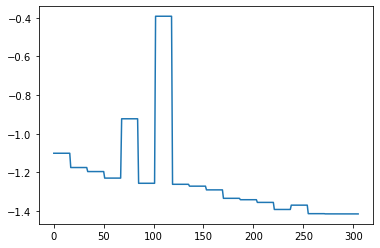

In [8]:
plt.plot(np.real(boltzmann.energy_optimization_history))

In [9]:
###exact solution###
def sigma_x_exact(N):
    """Applies sigma_x_i in form of tensor product"""
    sigma_matrix = np.matrix([[0,1],[1, 0]])
    ones_matrix = np.identity(2)
    final_hamiltonian = 0
    a = sigma_matrix
    for i in range(N):
        for j in range(1,N):
            if i == j:
                a = np.kron(a, sigma_matrix)
            else:
                a = np.kron(a, ones_matrix)
            
        final_hamiltonian += a
        a = ones_matrix
              
    return final_hamiltonian

def sigma_z_exact(N):
    """Applies sum sigma_z_i sigma_z_{i+1}
    on a given wavefunction psi and returns the 
    new wavefunciton"""
    n=2**N
    psi1 = np.identity(n)
    s = generate_spins(N)
    if N == 2:
        for i in range(n):
            for j in range(N):
                psi1[i, i] *= s[i,j]
    else: 
        psi1 = np.zeros((n,n))
        for i in range(n):
            for j in range(N):
                psi1[i][i] += (-1) ** (1 + (s[i][j] + s[i][(j + 1) % len(s[0])]) // 2) 
    return psi1



def hamiltonian_for_N_exact(N, h=0.5):
    return -h*sigma_x_exact(N)-sigma_z_exact(N)

def normalize_exact(N):
    """Gets psi from Hamiltonian and returns normalized psi"""
    H = hamiltonian_for_N_exact(N, 0.5)
    eig_H = np.linalg.eig(H)
    index_eigen_vector = np.argmin(eig_H[0])
    psi = eig_H[1][:,[index_eigen_vector]] #it's eigenvector for the ground state
    psi_star = np.transpose(np.conjugate(psi))
    
    return psi / np.sqrt(np.sum(psi_star @ psi))

In [10]:
Energy_exact = np.min(np.linalg.eigvals(hamiltonian_for_N_exact(6, h=0.5)))
print('Energy exact = ', Energy_exact)

Energy exact =  -6.384694563603683


## Part 2

In this section we find the spin correlation in order to see if the obtained wave-function is physical.

In [11]:
###Computing resulting value of spin correlation for BM solution###
def sigma_z_0_l(psi, l):
    """Applies  sigma_z_0 sigma_z_{l}
    on a given wavefunction psi and returns the 
    new wavefunciton"""
    n_spins = int(np.log2(len(psi)))
    s = generate_spins(n_spins)
    psi_sigma_z = np.zeros(len(psi), dtype = 'complex')
    for i in range(len(psi_sigma_z)):
        psi_sigma_z[i] = s[i][0] * s[i][l] * psi[i]
    return psi_sigma_z

def spin_correlation(psi):
    """Returns array C which contains the correlation between
    the spin at position 0 and the spin on position i. C is
    of the length N_spins + 1, and C[-1] is set to C[0] 
    for visual purposes"""
    psi = normalize(psi)
    psi_star = np.transpose(np.conjugate(psi))
    n_spins = int(np.log2(len(psi)))
    C = np.zeros(n_spins + 1)
    for i in range(n_spins):
        C[i] = psi_star @ sigma_z_0_l(psi, i)
        print(C)
    C[-1] = C[0]
    return C

In [12]:
###Computing resulting value of spin correlation for the exact solution###

def sigma_z_0_l_exact(N, l):
    """Applies  sigma_z_0 sigma_z_{l}
    on a given wavefunction psi and returns the 
    new wavefunciton"""
    n = 2**N
    n_spins = N
    s = generate_spins(n_spins)
    #print(s)
    sigma_z = np.zeros(n)
    for i in range(n):
        sigma_z[i] = (s[i][0] * s[i][l])
        #print(i, sigma_z[i])
    return np.diag(sigma_z)

def spin_correlation_exact(N):
    #psi_complex = np.zeros(2**N, dtype = 'complex')
    #for i in range(len(psi)):
    #    psi_complex[i] = psi[i]
    psi = normalize_exact(N)
    psi_star = np.transpose(np.conjugate(psi))
    
    n_spins = int(N)
    C = np.zeros(n_spins + 1)
    for i in range(n_spins):
        C[i] = np.real(psi_star @ sigma_z_0_l_exact(N, i)@psi)
        print(C)
    C[-1] = C[0]
    return C

In [13]:
N= 2
C_exact=spin_correlation_exact(N)

[1. 0. 0.]
[1.         0.70710678 0.        ]


[1. 0. 0.]
[1.         0.70709269 0.        ]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


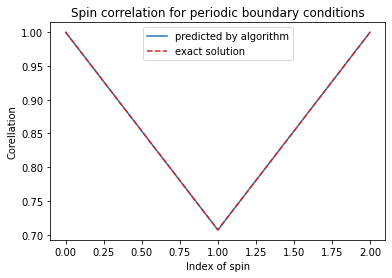

In [14]:
C = spin_correlation(psi_optimal)
plt.plot(np.real(C),color='tab:blue', linestyle='-', label="predicted by algorithm")
plt.plot(C_exact, color='tab:red', linestyle='--', label="exact solution" )
plt.title('Spin correlation for periodic boundary conditions')
plt.xlabel('lndex of spin')
plt.ylabel('Corellation')
plt.savefig('Figures\\Spin correlation ' + str(n) + ' spins, h = ' + str(h) + '.png')
plt.legend()


## Part 3

We modify the code from Part 1 to solve the system using stochastic gradient descent. This section is in progress, while the previous ones should be working completely.

In [15]:

def binary_to_decimal(s):
    """Returns the index correspoding to the state s"""
    ind = 0
    n = len(s)
    for i in range(n):
        if s[n - i - 1] == 1:
            ind += 2 ** i
    return ind

def index_of_spin(s):
    """Returns the index of a given spin"""
    n = len(s)
    ind = 0
    for i in range(n):
        if s[i] == 1:
            ind += 2 ** (n-i-1)
    return ind

def psi_diference(s, w, ind):    # Works for complex w, however, runtime errors
    """Returns a result of division of wave function with fliped spi by initial psi """
    #s_new[ind] = spin which was flipped
    a, b, W = w[0], w[1], w[2]
    div_psi = np.exp(-2*a[ind]*s[ind]) + 0.j
    p = store_constant(s, w)
    for i in range(len(W)):
        Fi_divided = (np.cosh(p[i]-2*W[i, ind]*s[ind]))/(np.cosh(p[i]))
        div_psi *= (Fi_divided)
    return div_psi

def store_constant(S, w):
    """Stores the constant (in form of array) to compute probapility (p) more eficcienly """
    a, b, W = w[0], w[1], w[2]
    p=np.zeros(len(b), dtype = 'complex')
    for i in range(len(W)):
        p[i] = b[i] + np.sum(W[i] * S)
    return p

def avg_energy_mc_efficient(w, N_steps):
    """Computes average energy using stochastic
    gradient descent"""
    global S
    s = rnd.choice(generate_spins(len(w[0])))
    s_hist = np.zeros(len(S))
    E = np.zeros(N_steps)
    for i in range(N_steps):
        E[i], s = monte_carlo_step_efficient(s, w, hamiltonian, boltzmann)
        s_hist[index_of_spin(s)] +=1
    print('Standard deviation efficient = ', np.std(np.real(E)))
    return np.real(np.average(E)), s_hist

def monte_carlo_step_efficient(s, w, hamiltonian, boltzmann):
    """For a given pure state in a given hamiltonian,
    does a monte_carlo_step on a pure state"""
    n_spin = len(s)

    ind = rnd.randint(0, n_spin - 1)
    s_new = s.copy()
    s_new[ind] *= -1
    # We compute the probability to accept the modification
    # as the ratio of psi_M(s_new) and psi_M(s)

    p = psi_diference(s, w, ind)

    if rnd.random() < np.absolute(p) ** 2:

        s = s_new

    # computing the change in the energy
    delta_E_mc = 0
    s_new = s.copy()
    for i in range(len(s)):    # sigma_x
        delta_E_mc += (-h) * psi_diference(s, w, i)
    if len(s) == 2:
        delta_E_mc -= s[0] * s[1]    # double_sigma_z for 2 spins
    else:
        delta_E_mc -= sum(s[i] * s[(i + 1) % len(s)] for i in range(len(s)))    # double_sigma_z
    return delta_E_mc, s




In [16]:
########### INITIALIZATION ########################
n = 2
S = generate_spins(n)
a = np.ones(n)
b = np.ones(n)
W = (np.random.rand(n,n) + 1j * np.random.rand(n,n)) * rnd.choice([-1, 1])
for i in range(len(a)): 
    a[i] *= rnd.uniform(-1,1)
    b[i] *= rnd.uniform(-1,1)
for i in range(len(a)):
    for j in range(len(a)):
        W[i][j] *= rnd.uniform(-1,1)
# a = np.random.rand(n) * rnd.choice([-1, 1])
# b = np.random.rand(n) * rnd.choice([-1, 1])
# W = (np.random.rand(n,n) + 1j * np.random.rand(n,n)) * rnd.choice([-1, 1])
w = a, b, W
h = 1
boltzmann = Boltzmann_N_spins(hamiltonian, n)
########### INITIALIZATION ########################


In [18]:
# For a given random state w, we compute the exact energy
# and compare to the energy computed by the markov chain
# using funciton psi_M directly and using more efficient way with storing data
import time
N_steps = 5000
t0 = time.time()
E_exact = boltzmann.avg_energy(boltzmann.compute_psi(w))
t1 = time.time()
# E_mc, s_hist = avg_energy_mc(w, N_steps)
t2 = time.time()
E_efficient_mc, s_hist = avg_energy_mc_efficient(w, N_steps)
t3 = time.time()
# E_efficient_efficient_mc, s_hist = avg_energy_mc_efficient_efficient(w, N_steps)
# t4 = time.time()
# print('E_mc = ', E_mc, 't = ', t2 - t1)
print('E_efficient_mc = ', E_efficient_mc, 't = ', t3 - t2)
# print('E_efficient_efficient_mc = ', E_efficient_efficient_mc, 't = ', t4 - t3)
print('E_exact = ', E_exact, 't = ', t1 - t0)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: ComplexWarning: Casting complex values to real discards the imaginary part


Standard deviation efficient =  0.5856055667528705
E_efficient_mc =  -1.840170310319875 t =  0.7594208717346191
E_exact =  -1.8301599495052254 t =  0.002346038818359375


In [19]:
def plot_psi_M_probability(w, boltzmann):
    a, b, W = w[0], w[1], w[2]
    S = generate_spins(len(W))
    p = np.zeros(len(S), dtype = 'complex')
    for i in range(len(S)):
        p[i] = np.absolute(boltzmann.psi_M(S[i], w)) ** 2
    p /= np.linalg.norm(p)
    #plt.plot(p[:])
    return p

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


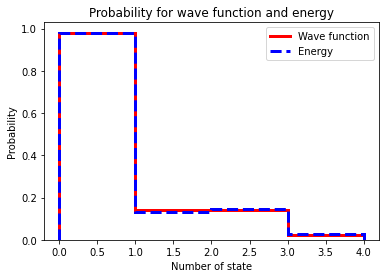

In [20]:
s_hist /= np.linalg.norm(s_hist)
plt.stairs(plot_psi_M_probability(w, boltzmann), color = 'red', linewidth= 3, label = "Square of |Psi_M| for s") 
plt.stairs(s_hist, color = 'blue',linewidth=3, linestyle='--', label = "Distribution of spin states")
plt.title('Probability for wave function and distribution of spins')
plt.xlabel('Index of state')
plt.ylabel('Probability')
plt.savefig('Figures\\Probability ' + str(n) + ' spins, h = ' + str(h) + '.png')
plt.legend()